# Building Complexity

<a href="https://colab.research.google.com/github/ledatelescope/bifrost/blob/master/tutorial/02_building_complexity.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>

The previous notebooks have shown how to work with data in Bifrost and highlighted several of its features.  We are now going to use that to build a more complete example of how data reduction can be done with Bifrost.



In [1]:
%%capture install_log
# Import bifrost, but attempt to auto-install if needed (and we're running on
# Colab). If something goes wrong, evaluate install_log.show() in a new block
# to retrieve the details.
try:
  import bifrost
except ModuleNotFoundError:
  try:
    import google.colab
    !sudo apt-get -qq install exuberant-ctags libopenblas-dev software-properties-common build-essential
    !pip install -q contextlib2 pint simplejson scipy git+https://github.com/ctypesgen/ctypesgen.git
    ![ -d ~/bifrost/.git ] || git clone https://github.com/ledatelescope/bifrost ~/bifrost
    !(cd ~/bifrost && ./configure && make -j all && sudo make install)
    import bifrost
  except ModuleNotFoundError:
    print("Sorry, could not import bifrost and we're not on colab.")

Let's start by taking in a collection of time domain complex voltage data for 16 inputs, transforming it to the frequency domain, and creating integrated spectra.  First, we need a time domain signal:

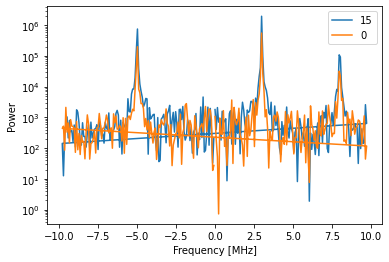

In [2]:
import numpy

ninput = 16
nchan = 256
ntime = nchan*32

def make_data(ntime, ninput):
    time = numpy.arange(ntime) / 19.6e6
    data = numpy.random.randn(ntime, ninput)
    data = data + 1j*numpy.random.randn(ntime, ninput)

    for freq,amp in ((-5e6,2), (3e6,3), (8e6,1)):
        for i in range(ninput):
            data[:,i] += amp*(1+i/ninput)*numpy.exp(2j*numpy.pi*freq*time)
    data = data.astype(numpy.complex64)
    return time, data

t, data = make_data(ntime, ninput)

import pylab
fdata = numpy.fft.fft(data[:nchan], axis=0)
freq = numpy.fft.fftfreq(fdata.shape[0], d=1/19.6e6)
pylab.semilogy(freq/1e6, numpy.abs(fdata[:,ninput-1])**2,
               label=str(ninput-1))
pylab.semilogy(freq/1e6, numpy.abs(fdata[:,0])**2,
              label='0')
pylab.xlabel('Frequency [MHz]')
pylab.ylabel('Power')
pylab.legend(loc=0);

That seems to be working with a quick check of the data using `numpy.fft.fft` and we can even see the different tone amplitudes across the inputs.

Now to translate this into Bifrost and do the integration in time:

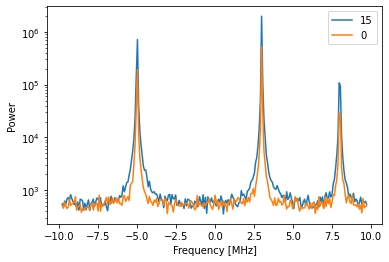

In [4]:
data = bifrost.ndarray(data, space='cuda')
data = data.reshape(-1,nchan,ninput)
fdata = bifrost.ndarray(shape=data.shape, dtype=data.dtype, space='cuda')

fft = bifrost.fft.Fft()
fft.init(data, fdata, axes=1, apply_fftshift=True)
fft.execute(data, fdata)

spectra = bifrost.ndarray(shape=(1,nchan,ninput), dtype=numpy.float32,
                          space='cuda')
bifrost.reduce(fdata, spectra, 'pwrmean')

spectra = spectra.copy(space='system')
spectra = spectra[0,:,:]
bf_freq = numpy.fft.fftshift(freq)
pylab.semilogy(bf_freq/1e6, spectra[:,ninput-1],
               label=str(ninput-1))
pylab.semilogy(bf_freq/1e6, spectra[:,0],
              label='0')
pylab.xlabel('Frequency [MHz]')
pylab.ylabel('Power')
pylab.legend(loc=0);

This works for a single batch of data, what we call a "gulp" in Bifrost. How do we extend this for working on a continuous stream of data?  We can first start by wrapping everything in a `for` loop as a stand-in for continuous data:

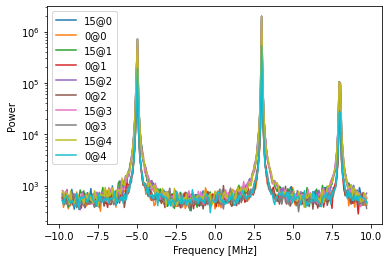

In [6]:
for gulp in range(5):
    t, data_noise = make_data(ntime, ninput)
    
    data_gpu = bifrost.ndarray(data_noise, space='cuda')
    data_gpu = data_gpu.reshape(-1,nchan,ninput)
    fdata = bifrost.ndarray(shape=data_gpu.shape, dtype=data_gpu.dtype,
                            space='cuda')
    
    fft = bifrost.fft.Fft()
    fft.init(data_gpu, fdata, axes=1, apply_fftshift=True)
    fft.execute(data_gpu, fdata)
    
    spectra = bifrost.ndarray(shape=(1,nchan,ninput), dtype=numpy.float32,
                              space='cuda')
    bifrost.reduce(fdata, spectra, 'pwrmean')

    spectra = spectra.copy(space='system')
    spectra = spectra[0,:,:]
    freq = numpy.fft.fftfreq(nchan, d=1/19.6e6)
    bf_freq = numpy.fft.fftshift(freq)
    pylab.semilogy(bf_freq/1e6, spectra[:,ninput-1],
                   label=f"{ninput-1}@{gulp}")
    pylab.semilogy(bf_freq/1e6, spectra[:,0],
                  label=f"0@{gulp}")
pylab.xlabel('Frequency [MHz]')
pylab.ylabel('Power')
pylab.legend(loc=0);

That works but it is not very efficient.  For every gulp we are creating new arrays on both the CPU and GPU memories and creating new `bifrost.fft` instances.  One way to deal with this is to pre-initialize the data arrays and the FFT function, and then use `bifrost.ndarray.copy_array` to copy data:

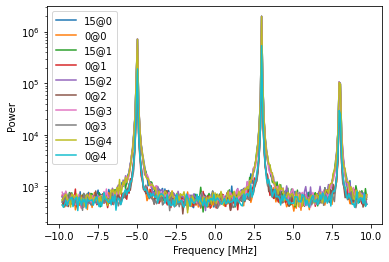

In [7]:
from bifrost.ndarray import copy_array

data_gpu = bifrost.ndarray(shape=(ntime//nchan, nchan, ninput),
                           dtype=numpy.complex64,
                           space='cuda')
fdata = bifrost.ndarray(shape=data_gpu.shape, dtype=data_gpu.dtype,
                        space='cuda')
spectra_gpu = bifrost.ndarray(shape=(1,nchan,ninput), dtype=numpy.float32,
                              space='cuda')
spectra_cpu = bifrost.ndarray(shape=(1,nchan,ninput), dtype=numpy.float32,
                              space='system')

fft = bifrost.fft.Fft()
fft.init(data_gpu, fdata, axes=1, apply_fftshift=True)

for gulp in range(5):
    t, data_noise = make_data(ntime, ninput)
    data_noise = bifrost.ndarray(data_noise, space='system')
    
    data_gpu = data_gpu.reshape(ntime,ninput)
    copy_array(data_gpu, data_noise)
    data_gpu = data_gpu.reshape(-1,nchan,ninput)
    
    fft.execute(data_gpu, fdata)
    
    bifrost.reduce(fdata, spectra_gpu, 'pwrmean')

    copy_array(spectra_cpu, spectra_gpu)
    
    freq = numpy.fft.fftfreq(nchan, d=1/19.6e6)
    bf_freq = numpy.fft.fftshift(freq)
    pylab.semilogy(bf_freq/1e6, spectra_cpu[0,:,ninput-1],
                   label=f"{ninput-1}@{gulp}")
    pylab.semilogy(bf_freq/1e6, spectra_cpu[0,:,0],
                  label=f"0@{gulp}")
pylab.xlabel('Frequency [MHz]')
pylab.ylabel('Power')
pylab.legend(loc=0)

del data_gpu
del fdata
del spectra_gpu
del spectra_cpu
del fft

This works well if you have a fixed channelization or integration time.  For pipelines where those parameters could change an alternative to pre-initilization is to wrap the data copies and FFT initialization in `try...except NameError` blocks:

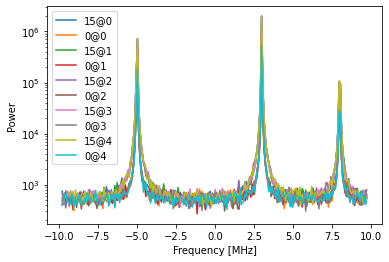

In [8]:
from bifrost.ndarray import copy_array

for gulp in range(5):
    t, data_noise = make_data(ntime, ninput)
    data_noise = bifrost.ndarray(data_noise, space='system')
    
    try:
        data_gpu = data_gpu.reshape(*data_noise.shape)
        copy_array(data_gpu, data_noise)
    except NameError:
        data_gpu = data_noise.copy(space='cuda')
    data_gpu = data_gpu.reshape(-1,nchan,ninput)
    
    try:
        fft.execute(data_gpu, fdata)
    except NameError:
        fdata = bifrost.ndarray(shape=data_gpu.shape,
                                dtype=data_gpu.dtype,
                                space='cuda')
        
        fft = bifrost.fft.Fft()
        fft.init(data_gpu, fdata, axes=1, apply_fftshift=True)
        fft.execute(data_gpu, fdata)
        
    try:
        bifrost.reduce(fdata, spectra_gpu, 'pwrmean')
    except NameError:
        spectra_gpu = bifrost.ndarray(shape=(1,nchan,ninput),
                                      dtype=numpy.float32,
                                      space='cuda')
        
        bifrost.reduce(fdata, spectra_gpu, 'pwrmean')
        
    try:
        copy_array(spectra_cpu, spectra_gpu)
    except NameError:
        spectra_cpu = spectra_gpu.copy(space='system')
        
    freq = numpy.fft.fftfreq(nchan, d=1/19.6e6)
    bf_freq = numpy.fft.fftshift(freq)
    pylab.semilogy(bf_freq/1e6, spectra_cpu[0,:,ninput-1],
                   label=f"{ninput-1}@{gulp}")
    pylab.semilogy(bf_freq/1e6, spectra_cpu[0,:,0],
                  label=f"0@{gulp}")
pylab.xlabel('Frequency [MHz]')
pylab.ylabel('Power')
pylab.legend(loc=0)

del fft
del data_gpu
del fdata
del spectra_gpu
del spectra_cpu

This structure allows you to initialize each array on the GPU only once and then reuse it as needed.  The only catch is that you need to cleanup after you are done processing gulps.  Otherwise, you can run into dimension mis-matches if the channel count or integration time changes.

These two examples are what are called "blocks" in Bifrost terminology and represent "atomic units" of data processing.  In the next section we will look at how Bifrost joins blocks together to build a pipeline.